In [ ]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import FinanceDataReader as fdr #pip3 install --user finance-datareader
from fredapi import Fred
import datetime, os


In [ ]:
ticker='SPY'
yf.pdr_override()
df_price = pdr.get_data_yahoo(ticker)

In [ ]:
start = df_price.index[0] 
end   = df_price.index[-1]
df_new_index = pd.date_range(start,end)
df_price = df_price.reindex(df_new_index)

df_price.isna().sum()
df_price.replace(np.NaN, 0, inplace=True)

for today in df_price.index:
  if df_price.loc[today,'Close'] == 0:
    df_price.loc[today]= df_price.loc[today-datetime.timedelta(days=1)]

In [ ]:
trading_df = pd.DataFrame(df_price['Close'],columns=['Close'])
trading_df['Qty']     = 0
trading_df['Capital'] = 0

In [ ]:
import datetime
from dateutil import relativedelta

def get_pivot(year, month, day):
  pivot_date = datetime.datetime.strptime("%d-%d-%d"%(year,month,day), "%Y-%m-%d")
  return pivot_date

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

def set_reblancing_date(trading_df, start_date, end_date):
  # Set pivot
  trading_df['Pivot'] = 0
  iter_date = start_date
  while iter_date <= end_date:
    AW_4_  = (iter_date.month==4)
    AW_11_ = (iter_date.month==11)
    if (AW_4_ or AW_11_):
      pivot_date = get_pivot(iter_date.year,iter_date.month,28)
      trading_df.loc[pivot_date,'Pivot'] = 1 
      print(pivot_date)
    iter_date = get_next_month(iter_date)
  return trading_df

In [ ]:
# Sim Env
## Date
start_date = datetime.datetime.strptime('2020-01-03', '%Y-%m-%d')
end_date = datetime.datetime.strptime('2022-01-03', '%Y-%m-%d')
period = (start_date <= trading_df.index) & (end_date >= trading_df.index)
trading_df = trading_df.loc[period]

trading_df = set_reblancing_date(trading_df,start_date, end_date)
trading_df['Pivot'].value_counts()

## Portpolio
init_capital = 1_000_000
qty = int(init_capital/df_price.loc[start_date, 'Close'])

<AxesSubplot:>

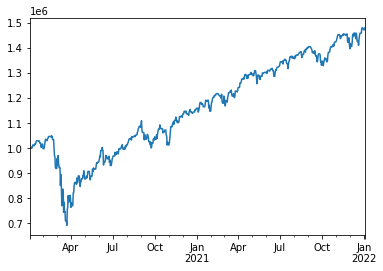

In [27]:
# Run
trading_df.loc[period, 'Qty'] = qty
trading_df['Capital'] = trading_df['Qty']*trading_df['Close']
trading_df['Capital'].plot()

In [ ]:
## Reblance

def reblance(portpolio_df):
  quater_total_capital = portpolio_df['Total_Capital']
  pass 





ratio = 0.3
quater_total_capital = init_capital




pivots = trading_df.loc[trading_df['Pivot']==1, ['Capital','Qty']]
pivots = pivots['Capital']
if pivots['Capital'] < quater_total_capital:
print(pivots)

## print
#